In [3]:
import os, pickle
from tqdm import tqdm  # Import tqdm for progress tracking
import numpy as np
import matplotlib.pyplot as plt
#import mdtraj as md
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
#import pyemma
#import pyemma.coordinates as coor
from joblib import Parallel, delayed

## Load in important functions

In [5]:
class Data:
    def __init__(self, array_list):
        self.arr`ay_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)
    

SyntaxError: invalid syntax (3437380628.py, line 3)

In [4]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

## Prepare the Data and make a new traj using state to indicate

In [5]:
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/data.pkl").array_list  # This is an (742, x, 3) array
# Convert each array in the list to float
all_omega = [arr.astype(float) for arr in all_omega]

# Apply omega2cistrans() to each array in all_omega
all_cistrans = [omega2cistrans(arr) for arr in all_omega]

# Print shape of the first converted array for verification
print(f"First array shape after conversion: {all_cistrans[0].shape}")

First array shape after conversion: (80085, 3)


In [6]:
# Find the minimum x-dimension across all arrays
max_x = max(arr.shape[0] for arr in all_cistrans)

print(f"larges x in all_cistrans: {max_x}")

all_cistrans

larges x in all_cistrans: 196095


[array([[1, 0, 1],
        [1, 0, 1],
        [1, 0, 1],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]]),
 array([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [1, 0, 1],
        [1, 0, 1],
        [1, 0, 1]]),
 array([[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]]),
 array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]),
 array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 array([[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        ...,
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 0]]),
 array([[1, 1, 0],
        [1, 1, 0],
        [1, 1, 0],
        ...,
        [1, 0, 1],
        

## Make transition matrix 

### Used Function

In [7]:
def state_to_index_vectorized(all_cistrans):
    """
    Converts a list of (3,) binary state arrays into indices (0-7),
    while preserving NaN values.
    """
    all_cistrans_array = np.array(all_cistrans, dtype=float)  # Allow NaN values

    if all_cistrans_array.ndim != 3 or all_cistrans_array.shape[-1] != 3:
        raise ValueError(f"Unexpected shape: {all_cistrans_array.shape}, expected (N, M, 3)")

    # Create a mask for NaN values
    nan_mask = np.isnan(all_cistrans_array).any(axis=-1)  # Shape: (N, M)

    # Convert binary states to indices where values are not NaN
    binary_weights = np.array([4, 2, 1])  # Weights for binary conversion (2^2, 2^1, 2^0)
    
    # Initialize the output array with NaN values
    indexed_states = np.full(all_cistrans_array.shape[:-1], np.nan)  # Shape: (N, M)

    # Apply binary conversion only to non-NaN rows
    valid_mask = ~nan_mask
    indexed_states[valid_mask] = np.dot(all_cistrans_array[valid_mask], binary_weights)

    return indexed_states  # Output is a 2D array of indices, with NaNs preserved

def index_to_state(index):
    """Converts an index (0-7) into a (3,) binary state array."""
    if not (0 <= index < 8):  # Ensure valid range (0-7)
        raise ValueError(f"Index out of range: {index}. Expected 0-7.")

    # Convert index to a 3-bit binary string
    binary_str = format(index, '03b')  # Example: 3 -> '011'
    
    # Convert binary string to NumPy array of integers
    state = np.array([int(bit) for bit in binary_str], dtype=int)

    return state

In [8]:
def compute_transition_matrix(subset, num_states, lagtime, pseudocount=0.25):
    """Compute transition matrix for a given subset of trajectories."""
    
    C = np.zeros((num_states, num_states))  # Initialize count matrix

    for traj in subset:
        for t in range(len(traj) - lagtime):
            from_state = traj[t]
            to_state = traj[t + lagtime]

            # Skip NaN transitions
            if np.isnan(from_state) or np.isnan(to_state):
                continue

            # Convert states to integers for indexing
            from_state = int(from_state)
            to_state = int(to_state)

            # Count transitions
            C[from_state, to_state] += 1.0

    # Add pseudocounts to avoid zero entries
    C += pseudocount

    # Normalize rows to get probabilities
    row_sums = C.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent division by zero
    T = C / row_sums        
    
    return T

In [9]:
def get_transition_matrices(n_trajs, num_states, lagtime, cluster_size=10, pseudocount=0.25, n_jobs=-1):
    """
    Compute transition matrices for subsets of trajectories in parallel.
    """

    num_trajs = n_trajs.shape[0]  # Number of trajectories
    
    # Shuffle indices
    indices = np.arange(num_trajs)
    np.random.shuffle(indices)

    # Split into clusters
    clusters = [indices[i:i + cluster_size] for i in range(0, num_trajs, cluster_size)]

    # Merge last small cluster with the second-last if needed
    if len(clusters) > 1 and len(clusters[-1]) < cluster_size:
        clusters[-2] = np.concatenate([clusters[-2], clusters[-1]])  
        clusters.pop()

    # Parallel computation of transition matrices
    def process_cluster(cluster):
        subset = n_trajs[cluster]
        # Call your existing compute_transition_matrix
        T = compute_transition_matrix(subset, num_states, lagtime, pseudocount)
        return T

    # Use joblib's Parallel for parallelism. 
    # `delayed(process_cluster)(c)` calls `process_cluster(c)` lazily.
    # `n_jobs=-1` uses all available CPUs unless specified otherwise.
    transition_matrices = Parallel(n_jobs=n_jobs)(
        delayed(process_cluster)(cluster) 
        for cluster in tqdm(clusters, desc="Computing transition matrices", unit="cluster")
    )

    return transition_matrices


In [10]:
def compute_stationary_distribution(T, lagtime):
    """Compute the stationary distribution of a transition matrix T.
    
    INPUT:
    T - Transition matrix where T_ij is the probability of transitioning i -> j.
    
    RETURN:
    pi - The stationary distribution (1D NumPy array).
    t2 - The implied timescale (in units of steps).
    """
    try:
        # Compute the implied timescale
        evals = np.linalg.eigvals(T.transpose() )  # will be something like [0.99754545 1.        ]
        evals_sorted = np.sort(evals)      # ascending order
        mu2 = evals_sorted[-2]            # second-largest eigenvalue
        #print('mu2', mu2, 'evals', evals, 'evals_sorted', evals_sorted, 'T', T)
        
        t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
        #print('evals_sorted', evals_sorted, 'mu2', mu2, 't2', t2)

        # Compute the stationary state distribution 
        n_states = T.shape[0]
        A = np.transpose(T) - np.eye(n_states)  # (T' - I)
        A = np.vstack([A, np.ones(n_states)])  # Append normalization row
        b = np.zeros(n_states + 1)
        b[-1] = 1  # Ensure probability sums to 1
        
        # Solve for stationary distribution using least squares
        pi, *_ = np.linalg.lstsq(A, b, rcond=None)
        
        # Ensure non-negative values and normalize
        pi = np.maximum(pi, 0)  # Prevent small negative values due to numerical error
        pi /= np.sum(pi)  # Normalize to sum to 1

    except Exception as e:
        print(f"Error computing stationary distribution: {e}")
        t2 = np.nan
        pi = None

    return pi, t2

## Compute the transition matrix

In [11]:
ntraj = len(all_omega)

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    traj[i, 0:n, :] = all_cistrans[i]

traj


maxlength 196095


array([[[ 1.,  0.,  1.],
        [ 1.,  0.,  1.],
        [ 1.,  0.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[ 1.,  1.,  0.],
        [ 1.,  1.,  0.],
        [ 1.,  1.,  0.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  0.,  1.],
        [ 1.,  0.,  1.],
        [ 1.,  0.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

In [12]:
print('traj.shape', traj.shape)

traj_indexed = state_to_index_vectorized(traj)

traj.shape (742, 196095, 3)


In [13]:
print('traj_indexed.shape', traj_indexed.shape)
traj_indexed

traj_indexed.shape (742, 196095)


array([[ 5.,  5.,  5., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       ...,
       [ 6.,  6.,  6., ..., nan, nan, nan],
       [ 5.,  5.,  5., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan]])

In [14]:
def process_trajectory(n_trajs, lagtime, num_states, cluster_size):

    # Calculate the transition matrix 
    transition_matrices = get_transition_matrices(n_trajs, num_states, lagtime, cluster_size, pseudocount=0.25, n_jobs=-1)
    transition_matrices = np.array(transition_matrices)
    #print('transition_matrices.shape', transition_matrices.shape)

    # Calculate the stationary population 
    pi_all = []
    t2_all = []

    
    for T in transition_matrices:
        pi, t2 = compute_stationary_distribution(T, lagtime)
        pi_all.append(pi)
        t2_all.append(t2)

    pi_all = np.array(pi_all)
    t2_all = np.array(t2_all)


    t2_mean = np.exp(np.mean([np.log(t2) for t2 in t2_all]))
    t2_std = np.exp(np.sqrt(np.var([np.log(t2) for t2 in t2_all])))
    pi_means = np.mean(pi_all, axis=0)  # Mean across trajectories
    pi_std = np.std(pi_all, axis=0)  # Standard deviation   
    
    return pi_means, pi_std, t2_mean, t2_std

#print(pi_all)

In [18]:
n_trajs = traj_indexed
num_states = 8
#lagtime = 1
lagtimes = [5, 10, 25, 50] + list(range(100, 80000, 500))
#lagtimes = [5, 10, 25, 50] + list(range(100, 20000, 500))
#lagtimes = [5, 10, 25, 50]
dt_in_ns = 0.01  
cluster_size = 10

# Store results
pi_all_means = []
pi_all_uppers = []
pi_all_lowers = []
pi_all_stds = []

# Store results
t2_all_means = []
t2_all_uppers = []
t2_all_lowers = []
t2_all_stds = []

for lagtime in tqdm(lagtimes, desc="Processing Lag Times", unit="lag"):
    
    pi_means, pi_std, t2_mean, t2_std = process_trajectory(n_trajs, lagtime, num_states, cluster_size)

    pi_uppers = pi_means + pi_std  # Upper bound
    pi_lowers = pi_means - pi_std  # Lower bound
    t2_uppers = t2_mean + t2_std  # Upper bound
    t2_lowers = t2_mean - t2_std  # Lower bound

    # Append to results
    pi_all_means.append(pi_means)
    pi_all_uppers.append(pi_uppers)
    pi_all_lowers.append(pi_lowers)
    pi_all_stds.append(pi_std)

    t2_all_means.append(t2_mean)
    t2_all_uppers.append(t2_uppers)
    t2_all_lowers.append(t2_lowers)
    t2_all_stds.append(t2_std)


# Convert to NumPy arrays
pi_all_means = np.array(pi_all_means)
pi_all_uppers = np.array(pi_all_uppers)
pi_all_lowers = np.array(pi_all_lowers)
pi_all_stds = np.array(pi_all_stds)
t2_all_means = np.array(t2_all_means)
t2_all_uppers = np.array(t2_all_uppers)
t2_all_lowers = np.array(t2_all_lowers)
t2_all_stds = np.array(t2_all_stds)
lagtimes_ns = np.array(lagtimes) * dt_in_ns

# Print final shapes
print("pi_all_means.shape:", pi_all_means.shape)  # (n_lagtimes, num_states)
print("pi_all_stds.shape:", pi_all_stds.shape)    # (n_lagtimes, num_states)
print("t2_all_means.shape:", t2_all_means.shape)  # (n_lagtimes, num_states)
print("t2_all_stds.shape:", t2_all_stds.shape)    # (n_lagtimes, num_states)

Computing transition matrices: 100%|███████| 74/74 [00:04<00:00, 18.27cluster/s]


Computing transition matrices:   0%|                | 0/74 [00:00<?, ?cluster/s]


Processing Lag Times:  59%|███████████▏       | 97/164 [15:04<09:20,  8.36s/lag]


Computing transition matrices: 100%|███████| 74/74 [00:03<00:00, 22.82cluster/s]


Computing transition matrices: 100%|███████| 74/74 [00:03<00:00, 22.89cluster/s]
/tmp/ipykernel_22004/606344109.py:18: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
Computing transition matrices: 100%|███████| 74/74 [00:03<00:00, 23.61cluster/s]


Processing Lag Times: 100%|██████████████████| 164/164 [23:46<00:00,  8.70s/lag]

pi_all_means.shape: (164, 8)
pi_all_stds.shape: (164, 8)
t2_all_means.shape: (164,)
t2_all_stds.shape: (164,)


In [20]:
# Create an instance of Data with your arrays
data_instance = Data([pi_all_means, pi_all_uppers, pi_all_lowers, pi_all_stds, 
                      t2_all_means, t2_all_uppers, t2_all_lowers, t2_all_stds, lagtimes_ns])

# Save to a file
#data_instance.save("autocoorel_data/stationary_distributions.pkl")
data_instance.save("autocoorel_data/stationary_distributions_800ns_5ns.pkl")

## Load the data and plot the fig of stationary population and implied timescale 

In [6]:
def index_to_state(index):
    """Converts an index (0-7) into a (3,) binary state array."""
    if not (0 <= index < 8):  # Ensure valid range (0-7)
        raise ValueError(f"Index out of range: {index}. Expected 0-7.")

    # Convert index to a 3-bit binary string
    binary_str = format(index, '03b')  # Example: 3 -> '011'
    
    # Convert binary string to NumPy array of integers
    state = np.array([int(bit) for bit in binary_str], dtype=int)

    return state

In [7]:
omega_loaded = Data.load("autocoorel_data/stationary_distributions_1800ns_5ns_clustersize100.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_uppers = omega_loaded[1]
pi_all_lowers = omega_loaded[2]
pi_all_stds = omega_loaded[3]
t2_all_means = omega_loaded[4]
t2_all_uppers = omega_loaded[5]
t2_all_lowers = omega_loaded[6]
t2_all_stds = omega_loaded[7]
lagtimes_ns = omega_loaded[8]

pi_all_means


array([[0.07747281, 0.06973392, 0.05973882, ..., 0.23107664, 0.15221155,
        0.17388289],
       [0.07962224, 0.07250735, 0.06207896, ..., 0.23003451, 0.1543872 ,
        0.16743706],
       [0.07715476, 0.07044348, 0.05882812, ..., 0.23382815, 0.15036669,
        0.16946157],
       ...,
       [0.11758174, 0.11758174, 0.11758174, ..., 0.12999946, 0.11758174,
        0.11758174],
       [0.11728873, 0.11728873, 0.11728873, ..., 0.129413  , 0.11728873,
        0.11728873],
       [0.11694134, 0.11694134, 0.11694134, ..., 0.12871769, 0.11694134,
        0.11694134]])

206.0:0.080 +- 0.022
206.0:0.072 +- 0.020
206.0:0.057 +- 0.020
206.0:0.063 +- 0.019
206.0:0.168 +- 0.047
206.0:0.236 +- 0.059
206.0:0.147 +- 0.034
206.0:0.178 +- 0.032


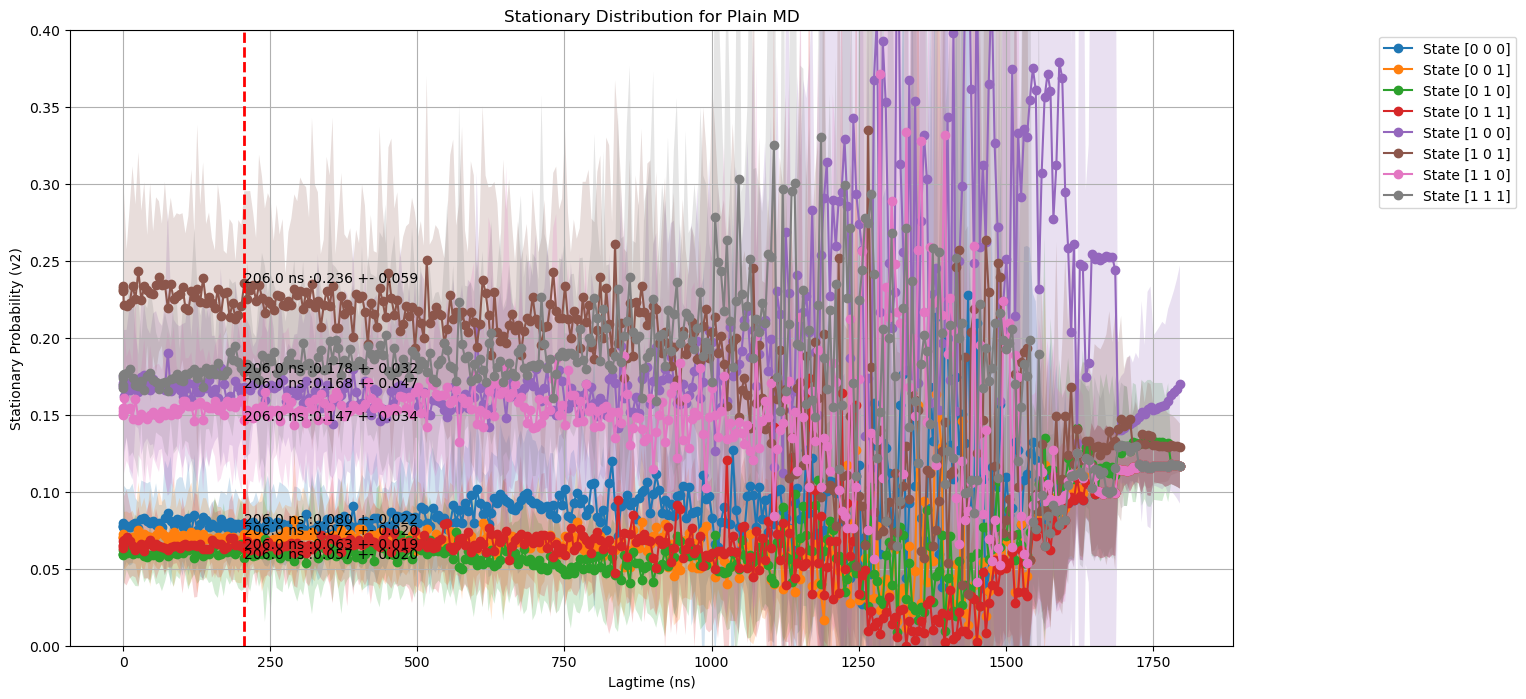

In [8]:
plt.figure(figsize=(15, 8))
state_to_plot = range(8)  # Fix: Select states 0 to 7

# Loop through selected states and plot each separately
for i, state in enumerate(state_to_plot):
    plt.plot(lagtimes_ns, pi_all_means[:, i], '-o', label=f'State {index_to_state(state)}')
        
    # Add shaded region for standard deviation
    plt.fill_between(lagtimes_ns, 
                     pi_all_means[:, i] + pi_all_stds[:, i],  # Upper bound
                     pi_all_means[:, i] - pi_all_stds[:, i],  # Lower bound
                     alpha=0.2)

    # Annotate the first point with its value
    first_x = lagtimes_ns[45]
    first_y = pi_all_means[45, i]
    first_y_var = pi_all_stds[45, i]
    plt.text(first_x, first_y,  f"{first_x} ns :{first_y:.3f} +- {first_y_var:.3f}", fontsize=10)
    print(f"{first_x}:{first_y:.3f} +- {first_y_var:.3f}")

plt.axvline(x=first_x, color='r', linestyle='--', linewidth=2)

plt.xlabel('Lagtime (ns)')
plt.ylabel('Stationary Probability (v2)')
plt.title('Stationary Distribution for Plain MD')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.ylim(0, 0.4)
plt.grid(True)
plt.show()


In [11]:
import pandas as pd

state_index = range(8)
state_num = 1
point_to_plot = 400
lagtime_plot = 45  # index of lagtime to extract at 101 ns
selected_ns = lagtimes_ns[lagtime_plot]  # for saving

# Prepare containers
cis_trans_pi_means = []
cis_trans_pi_stds = []
data_rows = []

for state in range(state_num):
    index = state_index  # since state_num = 1, this doesn't shift anything

    # Extract means and stds across lagtime dimension
    pi_means = pi_all_means[:, index]  # shape: (n_lagtime, 8)
    pi_stds = pi_all_stds[:, index]

    # Normalize across states for each lagtime
    row_sums = pi_means.sum(axis=1, keepdims=True)
    pi_means /= row_sums
    pi_stds /= row_sums  # assumes linear propagation of error (approximate)

    cis_trans_pi_means.append(pi_means)
    cis_trans_pi_stds.append(pi_stds)

    # Grab data for selected lagtime index
    for i, s in enumerate(index):
        data_rows.append({
            "thermo_state":0,
            "conform_state": s,
            "mean": pi_means[lagtime_plot, i],
            "std": pi_stds[lagtime_plot, i],
            "lagtime_ns": selected_ns
        })

# Create DataFrame
df = pd.DataFrame(data_rows)

# Save CSV
output_path = "autocoorel_data/trans_population_at_lagtime_8conform.csv"
df.to_csv(output_path, index=False)
print(f"Saved data to {output_path}")

df

Saved data to autocoorel_data/trans_population_at_lagtime_8conform.csv


,thermo_state,conform_state,mean,std,lagtime_ns
0,0,0,0.079614,0.022463,206.0
1,0,1,0.072289,0.020400,206.0
2,0,2,0.056757,0.020048,206.0
3,0,3,0.063460,0.018524,206.0
4,0,4,0.167872,0.046987,206.0
5,0,5,0.235856,0.059312,206.0
6,0,6,0.146623,0.033527,206.0
7,0,7,0.177528,0.031813,206.0


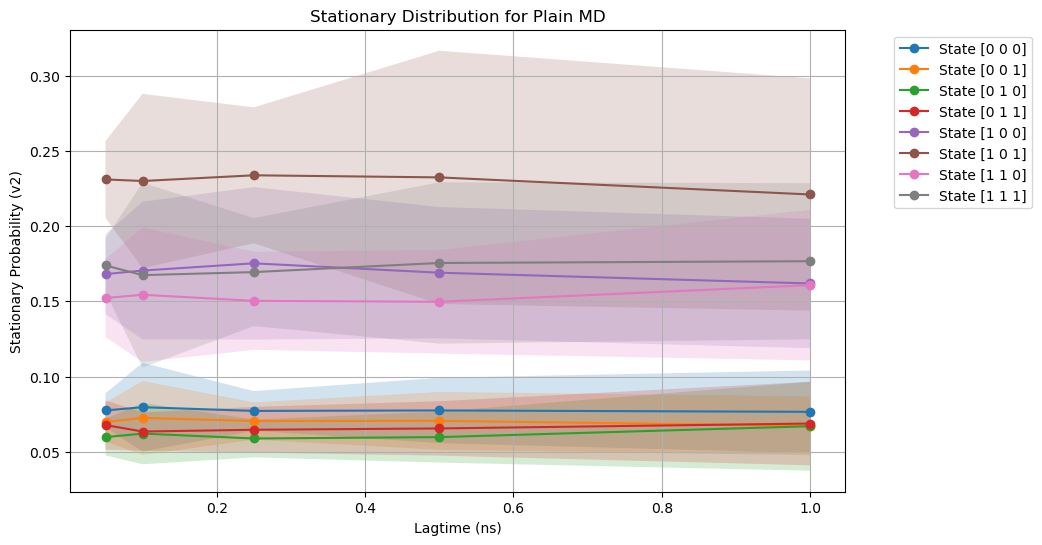

In [9]:
plt.figure(figsize=(10, 6))
state_to_plot = range(8)  # Fix: Select states 0 to 7
point_to_plot = 5
# Loop through selected states and plot each separately
for i, state in enumerate(state_to_plot):
    plt.plot(lagtimes_ns[:point_to_plot], pi_all_means[:point_to_plot, i], '-o', label=f'State {index_to_state(state)}')
        
    # Add shaded region for standard deviation
    plt.fill_between(lagtimes_ns[:point_to_plot], 
                     pi_all_means[:point_to_plot, i] + pi_all_stds[:point_to_plot, i],  # Upper bound
                     pi_all_means[:point_to_plot, i] - pi_all_stds[:point_to_plot, i],  # Lower bound
                     alpha=0.2)

plt.xlabel('Lagtime (ns)')
plt.ylabel('Stationary Probability (v2)')
plt.title('Stationary Distribution for Plain MD')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.show()


In [ ]:
lagtimes_ns.shape
t2_all_means.shape

In [ ]:
dt_in_ns = 0.01

plt.figure()
plt.plot(lagtimes_ns, t2_all_means*dt_in_ns, 'ko-')
plt.fill_between(lagtimes_ns, t2_all_uppers*dt_in_ns, t2_all_lowers*dt_in_ns, alpha=0.2)
plt.xlabel('lagtime (ns)')
plt.ylabel('implied timescale (ns)')

plt.yscale('log')
plt.ylim(5, 100000)
plt.title(f'Implied timescales for Plain MD')
plt.show()
